In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

def collapse_to_pitch_classes(pitch_vector_36d):
    """
    Reduce a 36-element pitch histogram to 12-element pitch class histogram.
    Assumes pitch_vector_36d[i] corresponds to MIDI pitch 48 + i (i.e., C3–B5).
    """
    pitch_vector_36d = np.array(pitch_vector_36d)
    pitch_class_vector = np.zeros(12)
    for i in range(len(pitch_vector_36d)):
        pitch_class_vector[i % 12] += pitch_vector_36d[i]
    if pitch_class_vector.sum() > 0:
        pitch_class_vector /= pitch_class_vector.sum()
    return pitch_class_vector

# Fix and parse keynorm_features strings into lists of floats
def parse_vector_string(s):
    # Remove brackets and split by number-like patterns
    return [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", str(s))]

df = pd.read_csv("../data/processed/parsed_tunes_with_keynorm_user_full.csv")

# Apply parsing
df["keynorm_features"] = df["keynorm_features"].apply(parse_vector_string)

df = df[df["keynorm_features"].notnull()].copy()
df = df[df["keynorm_features"].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) == 36)]
df["pitchclass_vector"] = df["keynorm_features"].apply(collapse_to_pitch_classes)

# Group by tune name and take the mean pitchclass vector per group
grouped = df.groupby("name")["pitchclass_vector"].apply(
    lambda vectors: np.mean(np.vstack(vectors), axis=0)
)

# Create a new DataFrame from this grouped data
df_unique = pd.DataFrame({
    "name": grouped.index,
    "pitchclass_vector": grouped.values
})

# Also include the most common mode_type for each tune
# (you can choose another strategy if you prefer)
mode_map = df.groupby("name")["mode_type"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
df_unique["mode_type"] = df_unique["name"].map(mode_map)
# Get the most common type per tune
type_map = df.groupby("name")["type"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
df_unique["type"] = df_unique["name"].map(type_map)


#df_unique.info()
#duplicate_names = df_unique["name"][df_unique["name"].duplicated()]
#print(f"Number of duplicate names: {duplicate_names.nunique()}")

# Convert to 2D NumPy array
X = np.vstack(df_unique["pitchclass_vector"].values)
y = df_unique["mode_type"].values

/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


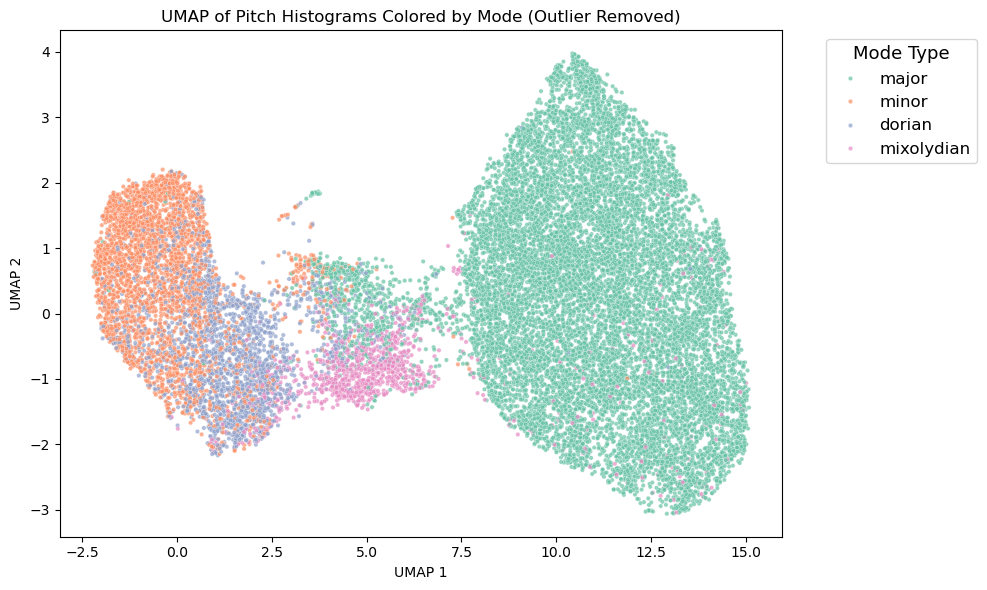

In [25]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
X_umap = umap_model.fit_transform(X)

df_unique["umap1"] = X_umap[:, 0]
df_unique["umap2"] = X_umap[:, 1]
df_plot = df_unique[df_unique["umap2"] < 7].copy()

# Update X_umap and y accordingly
X_umap_filtered = df_plot[["umap1", "umap2"]].values
y_filtered = df_plot["mode_type"].values





plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap_filtered[:, 0], y=X_umap_filtered[:, 1],
                hue=y_filtered, palette="Set2", alpha=0.7, s=10)

plt.title("UMAP of Pitch Histograms Colored by Mode (Outlier Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(
    title="Mode Type",
    title_fontsize="13",
    fontsize="12",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()


In [26]:
#reformat data frame for Streamlit

In [27]:
def reformat_name(name):
    if "," in name:
        parts = name.split(",")
        return parts[1].strip() + " " + parts[0].strip()
    return name

# Apply name cleaning
df_plot["name_clean"] = df_plot["name"].apply(reformat_name)

# Create master DataFrame for Streamlit
df_umap = pd.DataFrame(X_umap_filtered, columns=["x", "y"])
df_umap["name"] = df_plot["name_clean"].values
df_umap["mode"] = df_plot["mode_type"].values
df_umap["pitch_histogram"] = df_plot["pitchclass_vector"].values
df_umap["type"] = df_plot["type"].values



In [28]:
def find_nearest_tunes(df, target_name, n=5):
    target_row = df[df["name"] == target_name]
    if target_row.empty:
        print(f"Tune '{target_name}' not found.")
        return pd.DataFrame()
    
    target_vec = np.vstack(target_row["pitch_histogram"].values)
    target_type = target_row["type"].values[0]
    
    # Subset to only tunes of the same type
    same_type_df = df[df["type"] == target_type]
    
    all_vecs = np.vstack(same_type_df["pitch_histogram"].values)
    distances = euclidean_distances(target_vec, all_vecs)[0]
    
    same_type_df = same_type_df.copy()
    same_type_df["distance"] = distances
    
    result = same_type_df[same_type_df["name"] != target_name].sort_values("distance").head(n)
    return result[["name", "mode", "type", "distance"]]


In [29]:
example_tune = "The Silver Spear"
nearest = find_nearest_tunes(df_umap, example_tune)
print(nearest)


                      name   mode  type  distance
11502    The Magpie's Nest  major  reel  0.034030
6979         Gay Cassidy's  major  reel  0.040060
19168  Turkey In The Straw  major  reel  0.045341
7442        The Grand Spey  major  reel  0.046321
911                 Anne's  major  reel  0.046935


In [ ]:
df_umap.to_csv("../data/processed/parsed_tunes_with_keynorm_user_full.csv", index=False)